In [1]:
import arviz
import pymc as pm
import pandas as pd
import numpy as np
from causalgraphicalmodels import CausalGraphicalModel
import seaborn as sns

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


6E1. **List three mechanisms by which multiple regression can produce false inferences about causal effects.**
- post treatment bias,
- collider bias
-  multicolinearity

6M1. **Modify the DAG on page 186 to include the variable V, an unobserved cause of C and Y: C ← V → Y Reanalyze the DAG. How many paths connect X to Y? Which must be closed? Which variables should you condition on now?**

In [3]:
dag = CausalGraphicalModel(nodes = ['X',"Y","U","A","B","C","V"], 
                edges = [
                    ("X","Y"),
                    ("U","X"),
                    ('U',"B"),
                    ('A',"U"),
                    ('A',"C"),
                    ("V","C"),
                    ("V","Y"),
                    ('C',"B"),
                    ('C',"Y")])

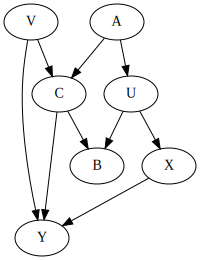

In [4]:
dag.draw() # Modified graph

In [5]:
backdoor_path = dag.get_all_backdoor_paths("X","Y") # Backdoor paths
backdoor_path

[['X', 'U', 'B', 'C', 'Y'],
 ['X', 'U', 'B', 'C', 'V', 'Y'],
 ['X', 'U', 'A', 'C', 'Y'],
 ['X', 'U', 'A', 'C', 'V', 'Y']]

In [6]:
backdoor_adju = dag.get_all_backdoor_adjustment_sets("X", "Y")
backdoor_adju

frozenset({frozenset({'U', 'V'}),
           frozenset({'A', 'B', 'U'}),
           frozenset({'A', 'C'}),
           frozenset({'U'}),
           frozenset({'C', 'U', 'V'}),
           frozenset({'B', 'U'}),
           frozenset({'B', 'U', 'V'}),
           frozenset({'A', 'U'}),
           frozenset({'A', 'B', 'U', 'V'}),
           frozenset({'C', 'V'}),
           frozenset({'A', 'U', 'V'}),
           frozenset({'C', 'U'}),
           frozenset({'A'}),
           frozenset({'A', 'C', 'U', 'V'}),
           frozenset({'A', 'B', 'C'}),
           frozenset({'A', 'C', 'U'}),
           frozenset({'B', 'C', 'V'}),
           frozenset({'B', 'C', 'U'}),
           frozenset({'B', 'C', 'U', 'V'}),
           frozenset({'A', 'B', 'C', 'V'}),
           frozenset({'A', 'B', 'C', 'U'}),
           frozenset({'A', 'V'}),
           frozenset({'A', 'C', 'V'}),
           frozenset({'A', 'B', 'C', 'U', 'V'})})

In [7]:
all_independencies = dag.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('U', 'V', set())
('U', 'Y', {'X', 'A'})
('U', 'Y', {'V', 'X', 'C'})
('U', 'C', {'A'})
('A', 'V', set())
('A', 'Y', {'V', 'U', 'C'})
('A', 'Y', {'V', 'X', 'C'})
('A', 'X', {'U'})
('A', 'B', {'U', 'C'})
('V', 'X', set())
('V', 'B', {'U', 'C'})
('V', 'B', {'A', 'C'})
('Y', 'B', {'U', 'C'})
('Y', 'B', {'X', 'A', 'C'})
('Y', 'B', {'V', 'X', 'C'})
('X', 'B', {'U'})
('X', 'C', {'U'})
('X', 'C', {'A'})


Paths from X to Y:
**five**
- X <-U <-A <-C <-V ->Y
- X <-U <-A <-C ->Y
- X -> Y
- X <-U -> B <-C <-V ->Y
- X <-U -> B <-C ->Y


### 6. M2

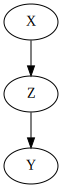

In [8]:
dag = CausalGraphicalModel(nodes = ['X',"Z", 'Y'], 
                edges = [
                    ("X","Z"),
                    ("Z","Y")]
)
dag.draw() 

In [9]:
x = np.random.normal(1, size= 1000)
z = np.random.normal(2*x, size = 1000)
y = np.random.normal(8, size= 1000)

In [10]:
pd.DataFrame({"x":x, "z":z, "y":y}).corr()

,x,z,y
x,1.000000,0.892256,0.004322
z,0.892256,1.000000,0.018913
y,0.004322,0.018913,1.000000


In [11]:
with pm.Model() as pipe:
    px= pm.Normal("px", mu=0, sigma=1)
    pz = pm.Normal("pz", mu=0, sigma=1)
    a = pm.Exponential("a", lam=1)

    mu = x*px + z*pz + a

    sigma = pm.Exponential("sigma", 5)
    py = pm.Normal("py", mu=mu, sigma=sigma, observed=y)

    sample = pm.sample(draws =200, chains = 2, return_inferencedata=True)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [px, pz, a, sigma]


KeyboardInterrupt: 

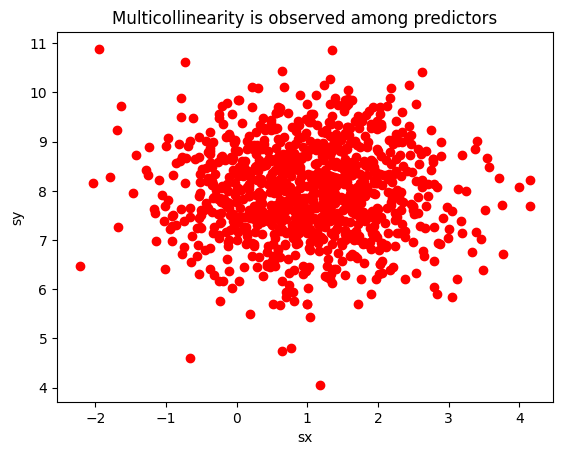

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, c="r")
ax.set_xlabel("sx")
ax.set_ylabel("sy")
ax.set_title("Multicollinearity is observed among predictors");

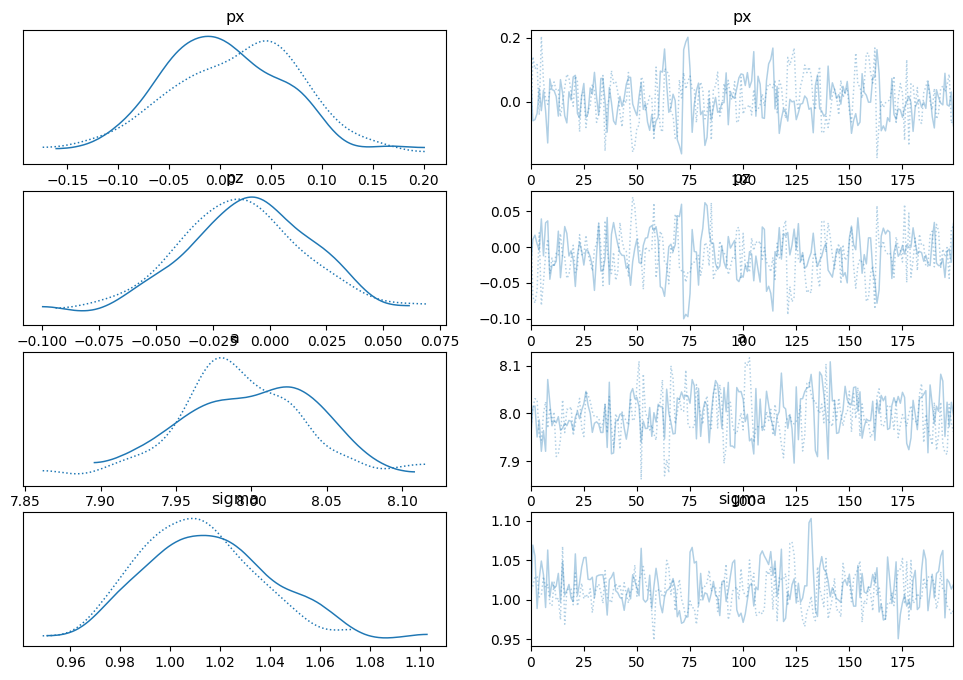

In [ ]:
arviz.plot_trace(sample, var_names=["px", "pz", "a", "sigma"]);

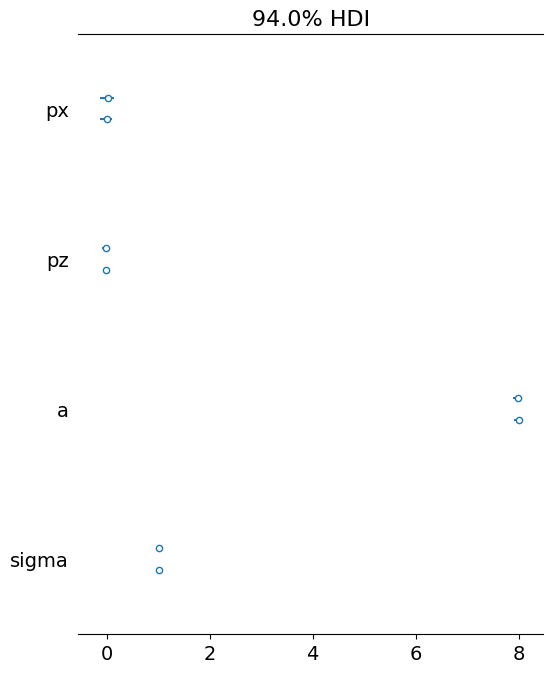

In [ ]:
arviz.plot_forest(sample);

In [ ]:
arviz.summary(sample, var_names=["px", "pz", "a", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
px,0.010,0.067,-0.137,0.116,0.004,0.004,262.0,192.0,1.00
pz,-0.011,0.030,-0.071,0.044,0.002,0.002,263.0,162.0,1.00
a,7.997,0.044,7.909,8.071,0.002,0.002,318.0,276.0,1.00
sigma,1.013,0.024,0.971,1.056,0.002,0.001,231.0,212.0,1.04


### 6. M3

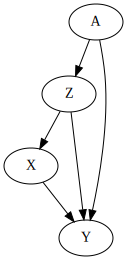

In [ ]:
dag = CausalGraphicalModel(nodes = ['X',"Z", 'Y','A'], 
                edges = [
                    ("X","Y"),
                    ("A","Y"),
                    ("A","Z"),
                    ("Z","Y"),
                    ("Z","X")]
)
dag.draw() 

Z

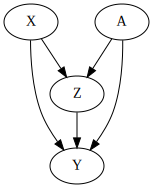

In [ ]:
dag = CausalGraphicalModel(nodes = ['X',"Z", 'Y','A'], 
                edges = [
                    ("X","Y"),
                    ("X","Z"),
                    ("A","Y"),
                    ("Z","Y"),
                    ("A","Z")]
)
dag.draw() 

-

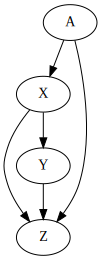

In [ ]:
dag = CausalGraphicalModel(nodes = ['X',"Z", 'Y','A'], 
                edges = [
                    ("X","Y"),
                    ("A","X"),
                    ("A","Z"),
                    ("X","Z"),
                    ("Y","Z")]
)
dag.draw() 

-

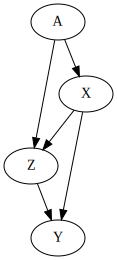

In [ ]:
dag = CausalGraphicalModel(nodes = ['X',"Z", 'Y','A'], 
                edges = [
                    ("X","Y"),
                    ("A","X"),
                    ("A","Z"),
                    ("X","Z"),
                    ("Z","Y")]
)
dag.draw() 

A

### 6. H1 

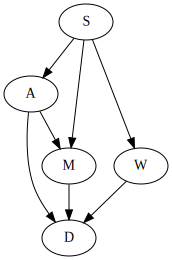

In [ ]:
Waffle = CausalGraphicalModel(
    nodes=["S", "M", "W", "A", "D"],
    edges=[
        ("S", "W"),
        ("S", "M"),
        ("S", "A"),
        ("A", "M"),
        ("A", "D"),
        ("M", "D"),
        ("W", "D"),
    ],
)

Waffle.draw()

In [13]:
data = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [ ]:
Waffle.get_all_backdoor_paths("W","D")

[['W', 'S', 'M', 'D'],
 ['W', 'S', 'M', 'A', 'D'],
 ['W', 'S', 'A', 'M', 'D'],
 ['W', 'S', 'A', 'D']]

In [ ]:
Waffle.get_all_backdoor_adjustment_sets("W","D")

frozenset({frozenset({'A', 'M'}),
           frozenset({'S'}),
           frozenset({'M', 'S'}),
           frozenset({'A', 'S'}),
           frozenset({'A', 'M', 'S'})})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

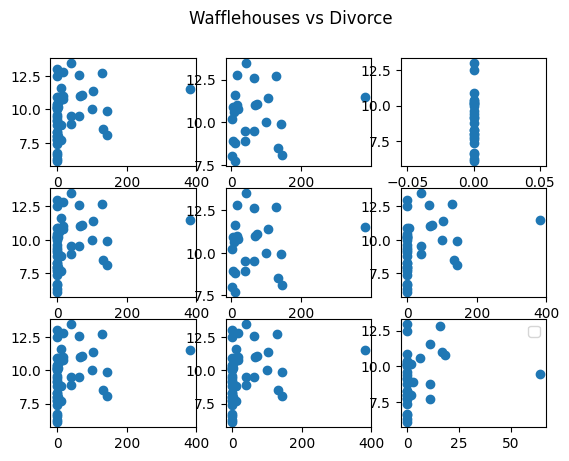

In [ ]:
fig, ax = plt.subplots(3, 3)
ax[0,0].scatter(data['WaffleHouses'], data['Divorce'])
plt.legend();
ax[0,1].scatter(data[data['WaffleHouses'] > np.median(data['WaffleHouses'])]['WaffleHouses'], data[data['WaffleHouses'] > np.median(data['WaffleHouses'])]['Divorce'])
plt.legend();
ax[0,2].scatter(data[data['WaffleHouses'] < np.median(data['WaffleHouses'])]['WaffleHouses'], data[data['WaffleHouses'] < np.median(data['WaffleHouses'])]['Divorce'])
plt.legend();
plt.suptitle('Wafflehouses vs Divorce');
ax[1,0].scatter(data['WaffleHouses'], data['Divorce'])
plt.legend();
ax[1,1].scatter(data[(data['WaffleHouses'] > np.median(data['WaffleHouses'])) | (data['South'] == 1)]['WaffleHouses'], data[(data['WaffleHouses'] > np.median(data['WaffleHouses'])) | (data['South'] == 1)]['Divorce'])
plt.legend();
ax[1,2].scatter(data[(data['WaffleHouses'] < np.median(data['WaffleHouses'])) | (data['South'] == 1)]['WaffleHouses'], data[(data['WaffleHouses'] < np.median(data['WaffleHouses'])) | (data['South'] == 1)]['Divorce'])
plt.legend();
ax[2,0].scatter(data['WaffleHouses'], data['Divorce'])
plt.legend();
ax[2,1].scatter(data[(data['WaffleHouses'] > np.median(data['WaffleHouses'])) | (data['South'] == 0)]['WaffleHouses'], data[(data['WaffleHouses'] > np.median(data['WaffleHouses'])) | (data['South'] == 0)]['Divorce'])
plt.legend();
ax[2,2].scatter(data[(data['WaffleHouses'] < np.median(data['WaffleHouses'])) | (data['South'] == 0)]['WaffleHouses'], data[(data['WaffleHouses'] < np.median(data['WaffleHouses'])) | (data['South'] == 0)]['Divorce'])
plt.legend();

In [14]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)
sw = standardize(data.WaffleHouses)

In [16]:
with pm.Model() as Waffle_model_conditioned:
    pw = pm.Normal("pw", mu=0, sigma=1,shape=2)
    a = pm.Exponential("a", lam=1,shape=2)
    sw = pm.Data("sw", sw)
    cid = pm.intX(pm.Data("cid", data["South"]))
    mu = pm.Deterministic("mu", pw[cid]*sw + a[cid])
    sigma = pm.Exponential("sigma", 5)

    py = pm.Normal("py", mu=mu, sigma=sigma, observed=standardize(data.Divorce))
    sample = pm.sample(draws =250, chains = 3, return_inferencedata=True)

e:\anaconda\envs\casual_inference\lib\site-packages\pymc\data.py:671: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [pw, a, sigma]


Sampling 3 chains for 1_000 tune and 250 draw iterations (3_000 + 750 draws total) took 113 seconds.
The acceptance probability does not match the target. It is 0.6438, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


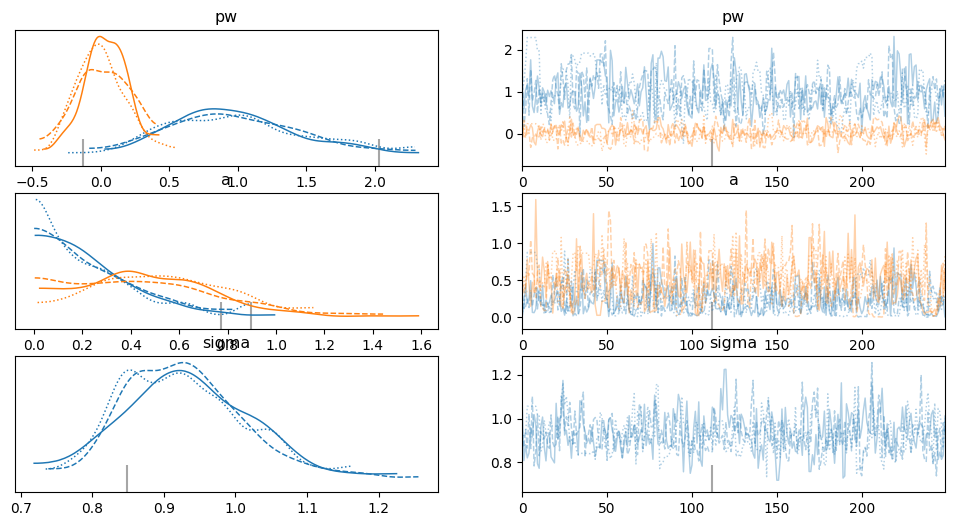

In [17]:
arviz.plot_trace(sample, var_names=["pw", "a", "sigma"]);

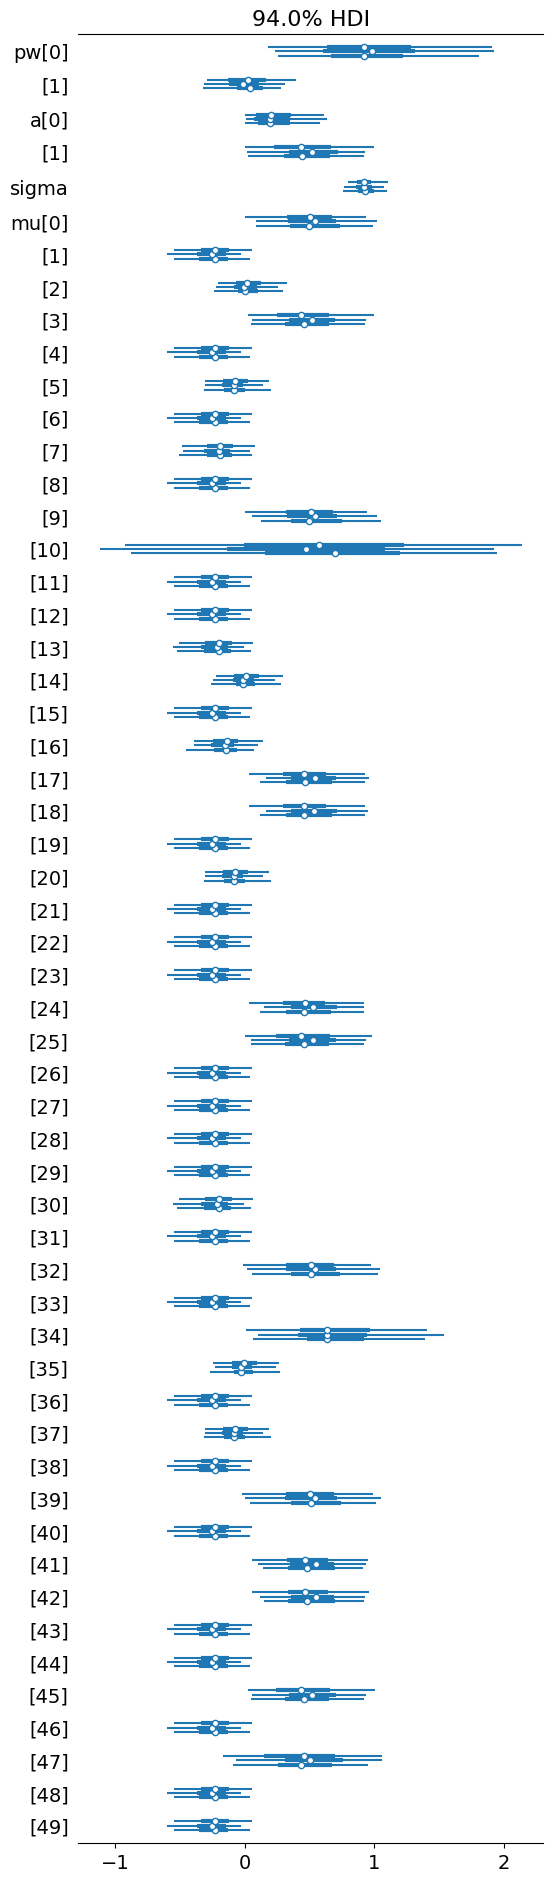

In [18]:
arviz.plot_forest(sample);

In [19]:
arviz.summary(sample, var_names=["pw", "a", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pw[0],0.982,0.468,0.235,1.923,0.032,0.026,247.0,197.0,1.01
pw[1],0.017,0.177,-0.308,0.343,0.009,0.006,407.0,428.0,1.02
a[0],0.244,0.198,0.000,0.607,0.014,0.010,211.0,219.0,1.00
a[1],0.495,0.286,0.002,0.954,0.015,0.011,287.0,154.0,1.01
sigma,0.930,0.088,0.758,1.082,0.004,0.003,417.0,429.0,1.00


In [ ]:
with pm.Model() as Waffle_model:
    pw = pm.Normal("pw", mu=0, sigma=1)
    a = pm.Exponential("a", lam=1)
    sw = pm.Data("sw", sw)
    mu = pw*sw + a
    sigma = pm.Exponential("sigma", 5)

    py = pm.Normal("py", mu=mu, sigma=sigma, observed=standardize(data.Divorce))
    sample = pm.sample(draws =250, chains = 2, return_inferencedata=True)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [pw, a, sigma]


Sampling 2 chains for 1_000 tune and 250 draw iterations (2_000 + 500 draws total) took 60 seconds.


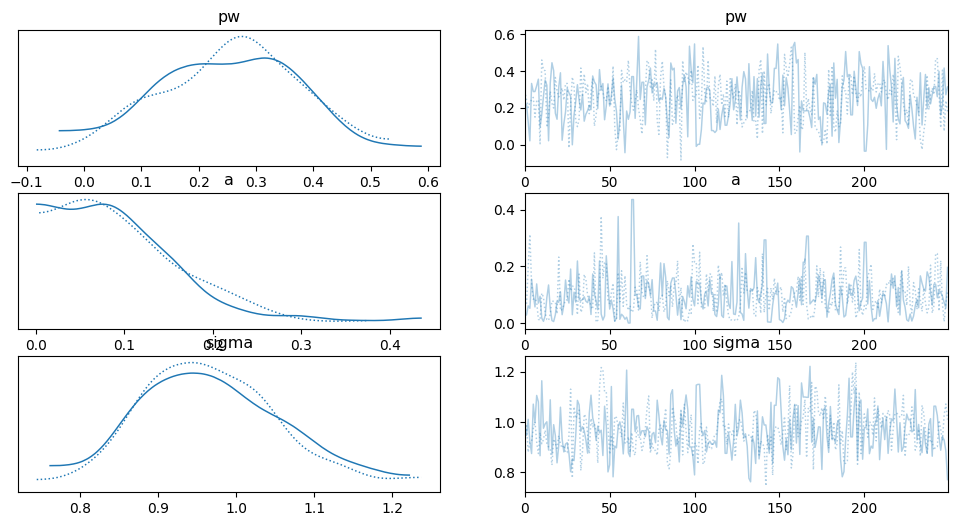

In [ ]:
arviz.plot_trace(sample, var_names=["pw", "a", "sigma"]);

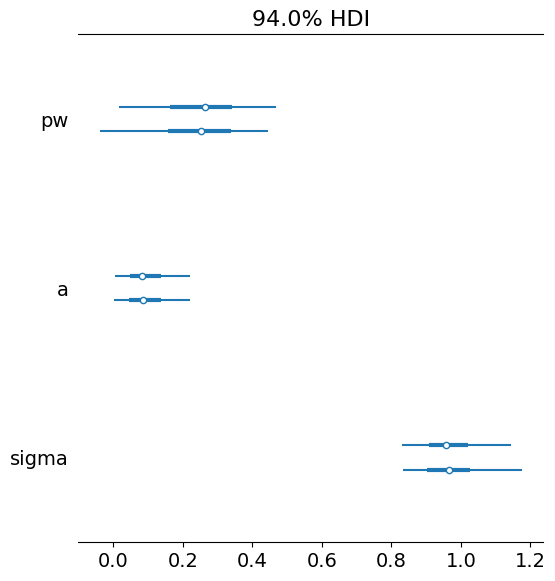

In [ ]:
arviz.plot_forest(sample);

In [ ]:
arviz.summary(sample, var_names=["pw", "a", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pw,0.252,0.128,0.002,0.469,0.007,0.005,367.0,382.0,1.0
a,0.098,0.071,0.003,0.220,0.004,0.003,325.0,352.0,1.0
sigma,0.967,0.088,0.828,1.156,0.005,0.004,326.0,320.0,1.0


### 6. H3

In [2]:
foxes = pd.read_csv("./data/foxes.csv", delimiter=";")

In [3]:
foxes.head()

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


In [4]:
fox_dag = CausalGraphicalModel(('A','F','G','W'),
                                 [('A','F'),('F','G'),('F','W'),('G','W')])

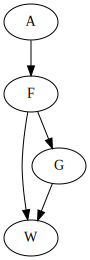

In [5]:
fox_dag.draw()

In [8]:
def standardize(x):
    return (x - np.mean(x)) / np.std(x)

fox_dag.get_all_backdoor_paths("A","W"), fox_dag.get_all_frontdoor_adjustment_sets("A","W")

([], frozenset({frozenset({'F'})}))

In [10]:
sA = standardize(foxes.area)
sF = standardize(foxes.avgfood)
sG = standardize(foxes.groupsize)
sW = standardize(foxes.weight)

In [25]:
with pm.Model() as fox_model:
    b = pm.Normal("b",mu=0, sigma=1)
    a = pm.Normal('a',mu=0, sigma=1)
    x = pm.Data("x", sA,mutable=True )
    mu = pm.Deterministic("mu",x*b +a)

    sigma = pm.Exponential("sigma",2)
    weights = pm.Normal("weight",mu,sigma,observed=sW)

    sample = pm.sample(draws=150, chains=2, return_inferencedata=True)
    prior_preds = pm.sample_prior_predictive(samples=500)

Only 150 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [b, a, sigma]


Sampling 2 chains for 1_000 tune and 150 draw iterations (2_000 + 300 draws total) took 32 seconds.
Sampling: [a, b, sigma, weight]


In [26]:
arviz.summary(sample, var_names=["b", "a", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b,0.009,0.087,-0.151,0.166,0.003,0.006,538.0,227.0,1.03
a,0.000,0.090,-0.162,0.146,0.004,0.005,598.0,211.0,1.01
sigma,1.006,0.062,0.891,1.122,0.003,0.002,498.0,257.0,1.00


In [30]:
with fox_model:
    pm.MutableData("o", np.linspace(-3, 3, 100))
    ppc = pm.sample_posterior_predictive(sample, 1000, var_names=["weight", "mu"])

IncorrectArgumentsError: Should not specify both keep_size and samples arguments. See the docstring of the samples argument for more details.

NameError: name 'ppc' is not defined

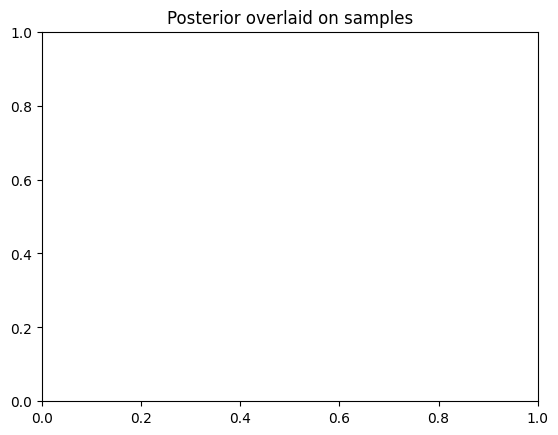

In [21]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()

x = np.linspace(-3, 3, 100)
ax.set_title("Posterior overlaid on samples")

# poster parameters
arviz.plot_hdi(x, ppc["mu"], ax=ax, color="grey")
ax.plot(x, ppc["mu"].mean(0), c="b", label="Mean parameter curve")

arviz.plot_hdi(
    x,
    ppc["weight"],
    ax=ax,
)

ax.scatter(sA, sw, c="red")
plt.xlabel("sa")
plt.ylabel("sw")
plt.legend();